In [5]:
import os
from utils import read_accs_from_folder
from utils import plot_acc_merged

ROOT = "./result-adaxeval"
model_name1 = "llm-jp-3-13b-exp1-multi-en_jstage"
model_name2 = "llm-jp-3-13b-exp1-multi-ja"

template = "prompt"
num_shot = 0

result_dir1 = os.path.join(ROOT, f"{model_name1}_{template}_{str(num_shot)}-shot")
result_dir2 = os.path.join(ROOT, f"{model_name2}_{template}_{str(num_shot)}-shot")

In [ ]:
import numpy as np

is_ood = False
delta_acc = False
df1 = read_accs_from_folder(result_dir1, model_name1, is_ood=is_ood, delta_acc=delta_acc)
df2 = read_accs_from_folder(result_dir2, model_name2, is_ood=is_ood, delta_acc=delta_acc)

def preprocess_df(df, model_name):
    if "ja" in model_name:
        source_lang, target_lang = "ja", "en"
    else:
        source_lang, target_lang = "en", "ja"
    sdf = df[~((df["eval_lang"] == target_lang) & (df["eval_type"] == "mem"))]

    conditions = [
        (sdf["eval_lang"] == source_lang) & (sdf["eval_type"] == "mem"),
        (sdf["eval_lang"] == source_lang) & (sdf["eval_type"] == "gen"),
        (sdf["eval_lang"] == target_lang) & (sdf["eval_type"] == "gen"),
    ]
    choices = ["Memorization", "Intralingual", "Interlingual"]
    sdf["label"] = np.select(conditions, choices, default="Other")
    return sdf


sdf1 = preprocess_df(df1, model_name1)
sdf2 = preprocess_df(df2, model_name2)

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os

def plot_acc_2panels(df_left, df_right):
    """
    Two side-by-side accuracy plots with shared y-axis.
    Legend above, global title below.
    """
    # --- Style ---
    sns.set_theme(style="whitegrid", font_scale=1.1)
    palette = {
        'Memorization': '#F9A037',
        'Intralingual': '#3D7AB3',
        'Interlingual': '#6AB187'
    }
    task_order = ["Memorization", "Intralingual", "Interlingual"]

    fig, axes = plt.subplots(1, 2, figsize=(7.5, 3.75), sharey=True, constrained_layout=True)

    def _plot(ax, df, is_left, subtitle):
        sns.lineplot(
            data=df, x='iter_num', y='acc',
            hue='label', hue_order=task_order,
            markers=True, marker='o',
            linewidth=3, markersize=6,
            palette=palette, ax=ax
        )
        ax.axvline(x=3841, color='red', linestyle='--', lw=1.5, label='1st Epoch')

        ax.set_xlabel("Iterations", fontsize=18)
        if is_left:
            ax.set_ylabel("Accuracy", fontsize=18)
        else:
            ax.set_ylabel("")
        ax.tick_params(axis='both', labelsize=16)
        ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
        ax.set_title(subtitle, fontsize=18, weight='bold')

        ax.xaxis.set_major_formatter(FuncFormatter(
            lambda x, _: '0' if x == 0 else f'{int(x/1000)}K'
        ))
        ax.set_ylim(0.25, 0.8)

    # Plot both panels
    _plot(axes[0], df_left, True, "English Training")
    _plot(axes[1], df_right, False, "Japanese Training")

    # Remove per-panel legends
    for ax in axes:
        leg = ax.get_legend()
        if leg: leg.remove()

    # Combined legend (top center)
    handles, labels = axes[0].get_legend_handles_labels()
    handle_dict = {l: h for l, h in zip(labels, handles)}

    ordered_handles = [handle_dict[t] for t in task_order if t in handle_dict]
    ordered_labels = [t for t in task_order if t in handle_dict]
    if '1st Epoch' in handle_dict:
        ordered_handles.append(handle_dict['1st Epoch'])
        ordered_labels.append('1st Epoch')

    fig.legend(
        ordered_handles, ordered_labels,
        loc='upper center', bbox_to_anchor=(0.51, 1.22),
        ncol=2, fontsize=18, frameon=True
    )

    # Save or show
    plt.tight_layout()
    result_dir = "./figures"
    plt.savefig(
        os.path.join(result_dir, "merged-monolingual-accuracy.pdf"),
        dpi=300, bbox_inches="tight"
    )


/tmp/ipykernel_1580736/2181222647.py:72: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


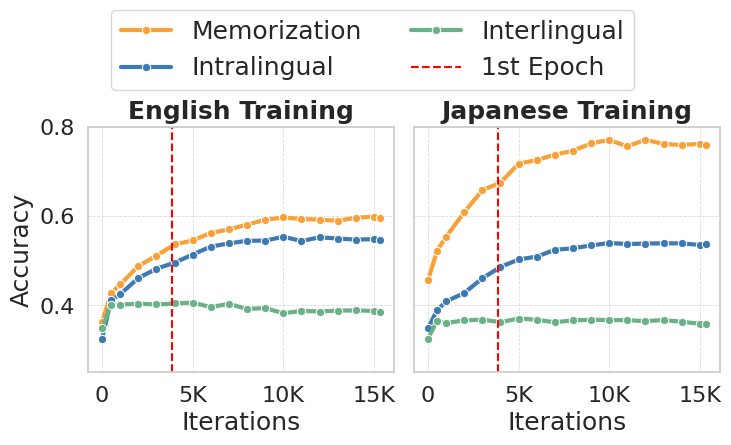

In [149]:
plot_acc_2panels(sdf1, sdf2)